Benchmark (model-free and model methods)
==========

Importing packages
------------------

In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, DynamicVAR
import statsmodels.api as sm
%matplotlib inline

C:\Users\Laurens\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b) Without predictors

Running Model-free benchmark models
------------------------------------

- 1/N Strategy (all assets equally weighted)
- Only in r (Risk free rate)
- Only in xs (stocks)
- Only in xb (bonds)


average TW (1/N): 1.19656709132
average TW (full r): 1.08880018824
average TW (full xs): 1.43191271231
average TW (full xb): 1.1297379508
st.dev TW (1/N): 0.140826525302
st.dev TW (full r): 0.0951966185811
st.dev TW (full xs): 0.387917446902
st.dev TW (full xb): 0.144814656555


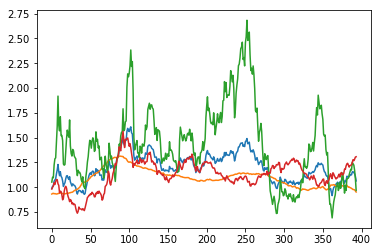

In [13]:
# Model-free benchmarks (1/N or full in the other assets)
# index 239 is the beginning of the out-of-sample analysis 754 (last)
a0 = [1/3,1/3,1/3]
a1 = [1,0,0]
a2 = [0,1,0]
a3 = [0,0,1]

r0list = []
r1list = []
r2list = []
r3list = []
for i in range(239,753-120):
    r0 = 0
    r1 = 0
    r2 = 0
    r3 = 0
    for j in range(1,60):
        s1 = data.iloc[i+j,1:4].values.reshape(1,3)
        r0 += sum(a0*s1[0])
        r1 += sum(a1*s1[0])
        r2 += sum(a2*s1[0])
        r3 += sum(a3*s1[0])
    # transform from cumulative log return to Terminal wealth (given starting wealth is normalized to 1)
    r0 = np.exp(r0)
    r1 = np.exp(r1)
    r2 = np.exp(r2)
    r3 = np.exp(r3)
    r0list.append(r0)
    r1list.append(r1)
    r2list.append(r2)
    r3list.append(r3)

# Plot the time series of Terminal Wealth
plt.plot(r0list)
plt.plot(r1list)
plt.plot(r2list)
plt.plot(r3list)

print('average TW (1/N): ' + str(np.mean(r0list)))
print('average TW (full r): ' + str(np.mean(r1list)))
print('average TW (full xs): ' + str(np.mean(r2list)))
print('average TW (full xb): ' + str(np.mean(r3list)))

print('st.dev TW (1/N): ' + str(np.sqrt(np.var(r0list))))
print('st.dev TW (full r): ' + str(np.sqrt(np.var(r1list))))
print('st.dev TW (full xs): '+ str(np.sqrt(np.var(r2list))))
print('st.dev TW (full xb): ' + str(np.sqrt(np.var(r3list))))

df = pd.DataFrame({'1/N':r0list, 'full r': r1list, 'full Xs':r2list,'full Xb':r3list})
df.to_excel('Results_MF_Benchmark.xlsx', sheet_name='sheet1')
    

Classical Portfolio management (VAR + Dynamic strategy)
-----------

In [5]:
# Model benchmark (classical portfolio management) NEEDS OPTIMIZATION ESPECIALLY FOR LARGER RUNS, sim and slice)
# expanding window + investment horizon = 5 years (K = 60)

# parsing data
dates = data['Date']
mdata = data[['r','xs','xb']]
mdata.index = pd.DatetimeIndex(dates)
n = data.size/4-4
periods = 60
simul = 400
beginperiod = 372
gamma = 10 #5 #2 
TW = []
MWeights = []
Index = []

for i in range(500,690):
# for i in range(beginperiod,int(n-periods-1)): #   n-periods-1): (possiblity to serialize) (Check 241 )
    # initialization
    optimalweights = np.zeros(periods-1)
    currentK = 0
    
    while currentK < periods-1:
        K = periods - currentK
        
        ## Simulate from the estimate VAR(1) model
        model = VAR(mdata[0:i+currentK]) # take a smaller range to improve speed (like i - 200)
        results = model.fit(1)   # fit a VAR(1) model on the data based on only the returns (no predictability)
        A = results.coefs
        sim = [[[0 for x in range(3)] for k in range(0,K)] for j in range(0,simul)]
        for j in range(0,simul):
            eps = np.sqrt(np.var(results.resid)).values.reshape(1,3)
            x0 = np.random.normal(0,eps[0][0],K)
            x1 = np.random.normal(0,eps[0][1],K)
            x2 = np.random.normal(0,eps[0][2],K)

            for k in range(0,K):
                if k == 0:
                    Ahat = mdata[i:i+1+currentK].values.dot(A[0].transpose())
                    Ahat = Ahat[0]
                else:
                    Ahat = np.array(np.array(sim[j][k-1]).dot(A[0].transpose()))
                sim[j][k][0] = Ahat[0] + x0[k]
                sim[j][k][1] = Ahat[1] + x1[k]
                sim[j][k][2] = Ahat[2] + x2[k]
                
        ## Calculate the optimal weights 
        W = np.linspace(0,1,10)
        Ufut = np.ones(simul)
        OptU = np.ones(simul)*-999
        OptW = np.zeros(simul)
        U = np.zeros(simul)

        for k in range(1,K+1):
            if k < K:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*(pow((w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2])),(1-gamma))*Ufut[j])
                        # Eventually K-k-1 because now i calculate fut Utility of time period T+K+1
                    slice = []
                    for x in range(0,simul):
                        slice.append(sim[x][K-k][1:3])
                    slice = sm.add_constant(slice)
                    olsmodel = sm.OLS(U, slice)
                    CU = olsmodel.fit()
#                     print(CU.params)
                    CU = np.sum(slice * CU.params, axis=1)
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w
                slicexs = []
                slicexb = []
                for x in range(0,simul):
                    slicexs.append(sim[x][K-k][1])
                    slicexb.append(sim[x][K-k][2])
                Ufut = (pow(OptW*np.exp(slicexs) + (1-OptW)*np.exp(slicexb),(1-gamma))*Ufut)
#                 print(OptW*np.exp(slicexs))
                OptU = np.ones(simul)*-999
                OptW = np.zeros(simul)
            else:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*((pow(w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2]),(1-gamma)))*Ufut[j])
                    olsmodel = sm.OLS(U, np.ones(simul))
                    CU = olsmodel.fit()
                    CU = np.ones(simul) * CU.params
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w

        optimalweights[currentK] = OptW[1] 
        currentK += 1
    print(i)
    
    # Calculate the Terminal Wealth from the given optimalweights  (Check whether indexes are right)
    TW.append(np.exp(sum(optimalweights*mdata[i+1:i+currentK+1]['xs'] + (1-optimalweights)*mdata[i+1:i+currentK+1]['xb'])))
    MWeights.append(np.mean(optimalweights))
    Index.append(i)
    #Turnover.append()
    #RU.append()
    
    print('Writing away results')
    df = pd.DataFrame({'index date':Index,'TW':TW, 'Mean Weights Xs':MWeights})
    df.to_excel('ResultsExp_CP_g10_gamma10_500_690.xlsx', sheet_name='sheet1', index=False)

500
Writing away results
501
Writing away results
502
Writing away results
503
Writing away results
504
Writing away results
505
Writing away results
506
Writing away results
507
Writing away results
508
Writing away results
509
Writing away results
510
Writing away results
511
Writing away results
512
Writing away results
513
Writing away results
514
Writing away results
515
Writing away results
516
Writing away results
517
Writing away results
518
Writing away results
519
Writing away results
520
Writing away results
521
Writing away results
522
Writing away results
523
Writing away results
524
Writing away results
525
Writing away results
526
Writing away results
527
Writing away results
528
Writing away results
529
Writing away results
530
Writing away results
531
Writing away results
532
Writing away results
533
Writing away results
534
Writing away results
535
Writing away results
536
Writing away results
537
Writing away results
538
Writing away results
539
Writing away results
